In [3]:
# import libraries
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [6]:
# get current working directory with os.getcwd()
print(os.getcwd())

os.chdir('/Users/finn/Desktop/intro_comp/Groupwork/')
print(os.getcwd())

/Users/finn/Desktop/intro_comp/Groupwork
/Users/finn/Desktop/intro_comp/Groupwork


In [7]:
def read_training_data(data_directory, split, classes, img_size):
    split_data = [[], [], []]
    classes_data = [[], [], []]

    for spl_index, spl in enumerate(split):
        for cla_index, cla in enumerate(classes):
            path = os.path.join(data_directory, spl, cla)
            class_num = classes.index(cla)
            for img in os.listdir(path):
                img_array = cv.imread(os.path.join(path, img), cv.IMREAD_GRAYSCALE)
                img_array = cv.resize(img_array, (img_size, img_size))
                split_data[spl_index].append(img_array)
                classes_data[spl_index].append(class_num)
            print(path, '(read', len(classes_data[spl_index]) ,'images)')
    return split_data, classes_data

In [8]:
def select_random_image(split_data, classes_data, split_set):
    rand_img_num = np.random.randint(0, len(split_data[split_set]))
    img = split_data[split_set][rand_img_num]
    img_label = classes_data[split_set][rand_img_num]
    return img, img_label, rand_img_num

In [9]:
def show_random_image(classes, classes_data, img, rand_img_num, split_set=0):
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title(classes[classes_data[split_set][rand_img_num]])
    plt.show()

In [10]:
def reshape_img(img):
    return np.reshape(img, (img.shape[0], img.shape[1], 1))

In [103]:
class conv_layer:
    """
    Convolution layer expects an input dimension (in_dim) of shape (h, w, d), where h and w
    are hight and width of images and d the number of dimensions. 

    Currently there is no padding or stride configuration. The layer operates with no paddling 
    and a stride of one.

    in_dim -> tuple of shape (h,w,d) -> input image dimensions 
    conv_size -> tuple of shape (h, w) -> size of convolution kernel
    kernel_num -> int -> number of kernels
    """
    def __init__(self, in_dim, conv_size=(3,3), kernel_num=4, debug = False):
        self.kernel_num = kernel_num
        self.conv_size = conv_size
        self.conv_kernels = [None] * self.kernel_num

        for i in range(0, self.kernel_num):
            if debug:
                self.conv_kernels[i] = self.debug_conv((conv_size[0], conv_size[1], in_dim[2]))
            else:
                self.conv_kernels[i] = np.random.uniform(0,1,(conv_size[0], conv_size[1], in_dim[2]))

        self.in_dim = in_dim
        self.out_dim = (self.in_dim[0] - (conv_size[0] - 1), self.in_dim[1] - (self.conv_size[1] - 1), self.kernel_num)
    
    '''
    perform a forward convolution on the specified image.

    img -> np.array of shape (h,w,d)
    
    ret:
    out_img -> np.array of shape (h,w,d)
    '''
    def forward(self, img):
        self.input = img
        out_img = np.zeros(self.out_dim)
        for k in range(0, self.kernel_num):
            for h in range(0, self.out_dim[0]):
                for w in range(0, self.out_dim[1]):
                    out_img[h, w, k] = np.sum(img[h:h+self.conv_size[0], w:w+self.conv_size[1],:] * self.conv_kernels[k])
        return out_img
    
    def backward(self, grad_output, learning_rate):
        grad_input = np.zeros(self.in_dim)
        for k in range(self.kernel_num):
            for h in range(self.out_dim[0]):
                for w in range(self.out_dim[1]):
                    grad_input[h:h+self.conv_size[0], w:w+self.conv_size[1], :] += grad_output[h, w, k] * self.conv_kernels[k]
                    self.conv_kernels[k] -= learning_rate * grad_output[h, w, k] * self.input[h:h+self.conv_size[0], w:w+self.conv_size[1], :]
        return grad_input

    '''
    get out put dimension of this network layer

    ret:
    out_dim -> tuple of shape (h,w,d)
    '''
    def get_out_dim(self):
        return self.out_dim
    
    def debug_conv(self, size):
        kernel = np.zeros(size)
        for i in range(0, size[0],2):
            kernel[i,:,:] = 1
        return kernel
    
class max_pooling_layer:
    """
    Max pooling layer expects an input dimension (in_dim) of shape (h, w, d), where h and w
    are hight and width of images and d the number of dimensions. 
    
    Currently there is no padding or stride configuration. The layer operates with no paddling 
    and a stride of one.

    in_dim -> tuple of shape (h,w,d) -> input image dimensions 
    pooling_size -> tuple of shape (h, w) -> size of pooling filter
    """
    def __init__(self, in_dim, pooling_size=(3,3)):
        self.pooling_size = pooling_size
        self.in_dim = in_dim
        h_overflow = 1 if self.in_dim[0] % self.pooling_size[0] > 0 else 0
        w_overflow = 1 if self.in_dim[1] % self.pooling_size[1] > 0 else 0
        self.out_dim = (int(self.in_dim[0] / self.pooling_size[0]) + h_overflow, int(self.in_dim[0] / self.pooling_size[0]) + w_overflow, self.in_dim[2])
        
    '''
    perform forward pooling on the specified image.

    img -> np.array of shape (h,w,d)
    
    ret:
    out_img -> np.array of shape (h,w,d)
    '''
    def forward(self, img):
        self.input = img
        out_img = np.empty(self.out_dim)
        h_overflow = True if self.in_dim[0] / self.pooling_size[0] - self.out_dim[0] > 0 else False
        w_overflow = True if self.in_dim[1] / self.pooling_size[1] - self.out_dim[1] > 0 else False
        for d in range(0, self.out_dim[2]):
            for w in range(0, self.out_dim[0]):
                for h in range(0, self.out_dim[1]):
                    pool_size_h = self.pooling_size[0]
                    pool_size_w = self.pooling_size[1]
                    if h_overflow and h == (self.out_dim[0]-1):
                        pool_size_h = self.in_dim[0] % self.pooling_size[0]
                    if h_overflow and h == (self.out_dim[0]-1):
                        pool_size_w = self.in_dim[1] % self.pooling_size[1]

                    out_img[h,w,d] = np.max(img[h*pool_size_h:h*pool_size_h+pool_size_h, w*pool_size_w:w*pool_size_w+pool_size_w,d])
        print('p1:', out_img.shape)
        return out_img
    
    """
    def backward(self, grad_output):
        grad_input = np.zeros(self.in_dim)
        for d in range(self.out_dim[2]):
            for w in range(self.out_dim[0]):
                for h in range(self.out_dim[1]):
                    pool_slice = self.input[w:w+self.pooling_size[0], h:h+self.pooling_size[1], d]
                    mask = (pool_slice == np.max(pool_slice))
                    grad_input[w:w+self.pooling_size[0], h:h+self.pooling_size[1], d] += mask * grad_output[w, h, d]
        return grad_input
    """
    def backward(self, grad_output):
        grad_input = np.zeros(self.in_dim)
        h_overflow = True if self.in_dim[0] / self.pooling_size[0] - self.out_dim[0] > 0 else False
        w_overflow = True if self.in_dim[1] / self.pooling_size[1] - self.out_dim[1] > 0 else False
    
        for d in range(self.out_dim[2]):
            for w in range(self.out_dim[0]):
                for h in range(self.out_dim[1]):
                    pool_size_h = self.pooling_size[0]
                    pool_size_w = self.pooling_size[1]
                    if h_overflow and h == (self.out_dim[0]-1):
                        pool_size_h = self.in_dim[0] % self.pooling_size[0]
                    if w_overflow and w == (self.out_dim[1]-1):
                        pool_size_w = self.in_dim[1] % self.pooling_size[1]
    
                    grad_slice = grad_output[w, h, d]
                    mask = (self.input[w*pool_size_h:w*pool_size_h+pool_size_h, h*pool_size_w:h*pool_size_w+pool_size_w, d] == np.max(self.input[w*pool_size_h:w*pool_size_h+pool_size_h, h*pool_size_w:h*pool_size_w+pool_size_w, d]))
                    grad_input[w*pool_size_h:w*pool_size_h+pool_size_h, h*pool_size_w:h*pool_size_w+pool_size_w, d] = mask * grad_slice
    
        return grad_input
    
    '''
    get out put dimension of this network layer

    ret:
    out_dim -> tuple of shape (h,w,d)
    '''
    def get_out_dim(self):
        return self.out_dim
    
# currently only ReLU activation function hardcoded
class relu_activation_layer:
    '''
    ReLU activation layer performs a ReLU function on each element in the input image. 
    This means it basically set everything to zero that is smaller then zero.

    in_dim -> tuple of shape (h,w,d) -> input image dimensions 
    '''
    def __init__(self, in_dim,):
        self.in_dim = in_dim

    def forward(self, img):
        self.input = img
        out_img = np.stack(np.vectorize(self.relu)(img), axis=0)
        return out_img

    def backward(self, grad_output):
        grad_input = grad_output * np.vectorize(self.relu)(self.input)
        return grad_input

    def relu(self, el):
        return(np.maximum(0, el))
    
class fully_connected_layer:
    '''
    The fully connected layer transforms the input into a fully connected network
    with an output vector of out_dim.

    in_dim -> tuple of shape (h,w,d) -> input image dimensions 
    out_dim -> int -> defines the number of output nodes
    '''
    def __init__(self, in_dim, out_dim):
        self.in_dim = in_dim
        self.out_dim = out_dim
        w_dim = 1
        for d in in_dim:
            w_dim = w_dim * d
        #self.weights = np.ones((self.out_dim, w_dim))
        self.weights = np.random.randn(self.out_dim, w_dim)
    
    
    def forward(self, img):
        self.img = img
        out_vec = np.zeros(self.out_dim)
        img_vec = img.flatten()

        for i in range(0, self.out_dim):
            out_vec[i] = np.sum(img_vec * self.weights[i])
        return out_vec
    
    def backward(self, grad_output, learning_rate):
        print('grad_output before reshape', grad_output)
        print('grad_output.shape before reshape', grad_output.shape)
        print('self.img.shape', self.img.shape)
        
        #grad_output = np.reshape(grad_output, (grad_output.shape[0], 1))
        #self.img = np.reshape(self.img, (1, self.img.shape[0]))
        #print('grad_output version 1:', grad_output)
        #print('self.img version 1:', self.img)
        grad_output = np.reshape(grad_output, (np.prod(grad_output.shape), 1))
        self.img = np.reshape(self.img, (1, np.prod(self.img.shape)))
        print('grad_output version 2:', grad_output)
        print('self.img version 2:', self.img)

        print()
        
        grad_weights = np.dot(grad_output, self.img)
        print('grad_weights.shape', grad_weights.shape)
        grad_input = np.dot(self.weights.T, grad_output)
        print('grad_input.shape', grad_input.shape)
        self.weights -= learning_rate * grad_weights
        print('self.weights.shape', self.weights.shape)
        print('bw f finished -----------------------------------')
        return grad_input
        
    
# class fully_connected_layer:
#     '''
#     The fully connected layer transforms the input into a fully connected network
#     with an output vector of out_dim.

#     in_dim -> tuple of shape (h,w,d) -> input image dimensions 
#     out_dim -> int -> defines the number of output nodes
#     '''
#     def __init__(self, in_dim, out_dim):
        
#         self.in_dim = in_dim
#         self.out_dim = out_dim

#         self.w_dim = np.prod(in_dim)
        
#         #self.weights = np.random.randn(self.out_dim, self.w_dim)
#         #self.weights = np.random.randn(self.out_dim, self.in_dim)
#         #self.bias = np.random.randn(self.out_dim, 1)

#     def forward(self, img):
#         self.input = img
        
#         self.out_vec = np.zeros(self.out_dim)
#         self.img_vec = img.flatten()

#         for i in range(0, self.out_dim):
#             #weight_vec = self.weights[i].reshape(img_vec.shape)
#             self.out_vec[i] = np.sum(self.img_vec * self.weights[i])
#             #out_vec[i] = np.sum(img_vec * weight_vec)
#         return self.out_vec
    
#     # def forward(self, img):
#     #     self.input = img
#     #     return np.dot(self.weights, self.input) #+ self.bias

#     def backward(self, grad_output, learning_rate):
#         grad_input = np.zeros(self.in_dim)
#         for i in range(self.out_dim):
#             #grad_input += grad_output[i] * self.weights[i]
#             grad_input += np.multiply(grad_output[i], self.weights[i].reshape(self.in_dim))
#             self.weights[i] -= learning_rate * grad_output[i] * self.input.flatten()
#         return grad_input
    
#     # def backward(self, grad_output, learning_rate):
#     #     grad_weights = np.dot(grad_output, self.input.T)
#     #     grad_input = np.dot(self.weights.T, grad_output)

#     #     self.weights -= learning_rate * grad_weights
#     #     #self.bias -= learning_rate * grad_output
#     #     return grad_input

    def get_out_dim(self):
        return self.out_dim
    
class conv_to_fc_reshape:
    '''
    '''
    def __init__(self, in_dim, out_dim):
        self.in_dim = in_dim
        self.out_dim = out_dim

    def forward(self, img):
        return np.reshape(img, self.out_dim)
    
    def backward(self, grad_output, learning_rate):
        return np.reshape(grad_output, self.in_dim)
                 
class sigmoid_activation_layer(): #(general_activation_layer):
    '''
    '''
    def __init__(self):
        pass

    def sigm(x):
        sigm_res = 1 / (1 + np.exp(-x))
        return sigm_res
    
    def sigm_deriv(x):
        sigm_deriv_res = sigm(x) * (1 - sigm(x))
        return sigm_deriv_res
        
        # super().__init__(sigm, sigm_deriv)
    
    def forward(self, img):
        self.input = img
        self.sigm_res = 1 / (1 + np.exp(-self.input))
        fw_res = self.sigm_res
        return fw_res
    
    def backward(self, grad_output, learning_rate):
        sigm_deriv_res = self.sigm_res * (1 - self.sigm_res)
        print('sig bw:' , grad_output.shape, sigm_deriv_res.shape)
        print('sig bw r:', grad_output, sigm_deriv_res)
        self.bw_res = np.multiply(grad_output, sigm_deriv_res)
        return self.bw_res

def bin_cross_entropy(y_true, y_pred):
    '''
    '''
    bin_cross_entropy_res = -np.mean(y_true*np.log(y_pred)+(1-y_true)*np.log(1-y_pred))
    return bin_cross_entropy_res

def bin_cross_entropy_deriv(y_true, y_pred):
    '''
    '''
    bin_cross_entropy_deriv_res = (1/np.size(y_true))*(((1-y_true)/(1-y_pred))-(y_true/y_pred))
    return bin_cross_entropy_deriv_res


In [102]:
# array of random values with shape (7, 7, 2) 
a_test = np.random.randn(74, 74, 2)
b_test = np.random.randn(10, 10)

a_test = np.reshape(a_test, (1, np.prod(a_test.shape)))
b_test = np.reshape(b_test, (np.prod(b_test.shape), 1))

#print(np.reshape(a_test.shape, (np.prod(a_test.shape), 1)))

np.dot(b_test, a_test).shape

(100, 10952)

In [104]:
print(img.shape)
img = reshape_img(img)
print(img.shape)

learning_rate = 0.01
c1 = conv_layer(in_dim=img.shape, conv_size=(3,3), kernel_num=2)
p1 = max_pooling_layer(in_dim=c1.get_out_dim(), pooling_size=(3,3))
#re1 = conv_to_fc_reshape(in_dim=p1.get_out_dim(), out_dim=(np.prod(p1.get_out_dim()), 1))
sig1 = sigmoid_activation_layer()
f1 = fully_connected_layer(in_dim=p1.get_out_dim(), out_dim=100)
sig2 = sigmoid_activation_layer()
f2 = fully_connected_layer(in_dim=(f1.get_out_dim(), 1), out_dim=2)
sig3 = sigmoid_activation_layer()

loss = 0

#print("before cnn")
#print(img)
fw = c1.forward(img)
#print("after conv forward")
#print(fw)
fw = p1.forward(fw)
#print("after pooling forward")
#print(fw)
#print("before sigmoid c1")
fw = sig1.forward(fw)
print(fw)
#print("after sigmoid c1")
#print(fw)
#print('before reshape')
# fw = re1.forward(fw)
#print('after reshape')
#print(fw)
#print("before fully connected")
fw = f1.forward(fw)
print("after fully connected 1")
print(fw)
#print("before sigmoid f1")
fw = sig2.forward(fw)
#print("after sigmoid f1")
#print(fw)
#print('f1.get_out_dim()',f1.get_out_dim())
fw = f2.forward(fw)
#print("after fully connected 2")
#print(fw)
#print("before sigmoid f2")
fw = sig3.forward(fw)
#print("after sigmoid f2")
#print(fw)


loss += bin_cross_entropy(img_label, fw)
grad = bin_cross_entropy_deriv(img_label, fw)

print('loss', loss)
print('grad', grad)

print('before sigmoid f2 backward')
grad = sig3.backward(grad, learning_rate)
print(grad)
print('before f2 backward')
grad = f2.backward(grad, learning_rate)
#print(grad)
print('before sigmoid f1 backward')
grad = sig2.backward(grad, learning_rate)
print(grad)
print('before f1 backward')
grad = f1.backward(grad, learning_rate)
print(grad)
print('before sigmoid p1 backward')
grad = sig1.backward(grad, learning_rate)
print(grad)
print('before p1 backward')
grad = p1.backward(grad)
print(grad)
print('before c1 backward')
grad = c1.backward(grad, learning_rate)
print(grad)

(224, 224, 1)
(224, 224, 1)
p1: (74, 74, 2)
[[[1.         1.        ]
  [1.         1.        ]
  [1.         1.        ]
  ...
  [1.         1.        ]
  [1.         1.        ]
  [1.         1.        ]]

 [[1.         1.        ]
  [1.         1.        ]
  [1.         1.        ]
  ...
  [1.         1.        ]
  [1.         1.        ]
  [1.         1.        ]]

 [[1.         1.        ]
  [1.         1.        ]
  [1.         1.        ]
  ...
  [1.         1.        ]
  [1.         1.        ]
  [1.         1.        ]]

 ...

 [[0.5        0.5       ]
  [0.99999972 0.99999205]
  [1.         1.        ]
  ...
  [0.5        0.5       ]
  [0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.99999951 0.9999941 ]
  [1.         1.        ]
  ...
  [0.5        0.5       ]
  [0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.99999755 0.99995747]
  [1.         1.        ]
  ...
  [0.5        0.5       ]
  [0.5        0.5   

ValueError: shapes (10952,100) and (10000,1) not aligned: 100 (dim 1) != 10000 (dim 0)

In [55]:
# reshape (5,) to (5,1)
hdrt = np.reshape(hdrt, (1, 5))
# reshape (2,) to (1, 2)
two = np.reshape(two, (2, 1))

In [56]:
print(hdrt.shape)
print(two.shape)
print(np.dot(two, hdrt).shape)

(1, 5)
(2, 1)
(2, 5)


In [ ]:
# create an array with shape (74, 74, 2) and random values
im_age = np.random.randn(74, 74, 2)
im_age = im_age.reshape(74*74*2, 1)

im_age_2 = np.random.randn(100, 10952)
res_im_age = np.dot(im_age_2, im_age)

#(5, 26, 26), (5 * 26 * 26, 1)

In [96]:
# test them in succession

#img = np.ones((6, 6, 1))

# index = 0
# for k in range(0,img.shape[0]):
#     for h in range(0,img.shape[1]):
#         img[k, h] = index
#         index += 1

print(img.shape)
img = reshape_img(img)
print(img.shape)

learning_rate = 0.01

c1 = conv_layer(in_dim=img.shape, conv_size=(3,3), kernel_num=2)
a1 = relu_activation_layer(in_dim=c1.get_out_dim())
p1 = max_pooling_layer(in_dim=c1.get_out_dim(), pooling_size=(3,3))
f1 = fully_connected_layer(in_dim=p1.get_out_dim(), out_dim=10)
sm1 = sigmoid_activation_layer(in_dim=f1.get_out_dim())
print("before cnn")
print(img)
k = c1.forward(img)
print("after conv forward")
print(k)
k = a1.forward(k)
print("after relu activation forward")
print(k)
k = p1.forward(k)
print("after pooling forward")
print(k)
k = f1.forward(k)
print("after fully connected forward")
print(k)
k = sm1.forward(k)
print("after sigmoid activation forward")
print(k)

loss = k - img_label

k = sm1.backward(loss, learning_rate)
print("after sigmoid activation backward")
print(k)
k = f1.backward(k, learning_rate)
print("after fully connected backward")
print(k)
k = p1.backward(k, learning_rate)
print("after pooling backward")
print(k)
k = a1.backward(k)
print("after relu activation backward")
print(k)
k = c1.backward(k, learning_rate)
print("after conv backward")
print(k)

(224, 224, 1)
(224, 224, 1)


TypeError: sigmoid_activation_layer.__init__() got an unexpected keyword argument 'in_dim'

## testing

### test all layers

In [12]:
data_directory = 'Group1/data/'
split = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']
img_size = 224

split_data, classes_data = read_training_data(data_directory, split, classes, img_size)

Group1/data/train/NORMAL (read 966 images)
Group1/data/train/PNEUMONIA (read 3756 images)
Group1/data/val/NORMAL (read 107 images)
Group1/data/val/PNEUMONIA (read 417 images)
Group1/data/test/NORMAL (read 268 images)
Group1/data/test/PNEUMONIA (read 1043 images)


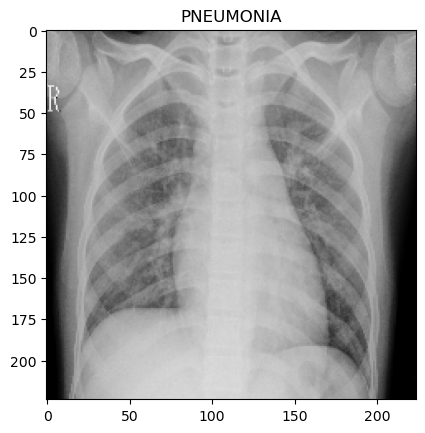

In [13]:
img, img_label, rand_img_num = select_random_image(split_data, classes_data, split_set=0)
show_random_image(classes, classes_data, img, rand_img_num, split_set=0)

In [38]:
# test them in succession

#img = np.ones((6, 6, 1))

# index = 0
# for k in range(0,img.shape[0]):
#     for h in range(0,img.shape[1]):
#         img[k, h] = index
#         index += 1

print(img.shape)
img = reshape_img(img)
print(img.shape)

learning_rate = 0.01

c1 = conv_layer(in_dim=img.shape, conv_size=(3,3), kernel_num=2)
a1 = relu_activation_layer(in_dim=c1.get_out_dim())
p1 = max_pooling_layer(in_dim=c1.get_out_dim(), pooling_size=(3,3))
f1 = fully_connected_layer(in_dim=p1.get_out_dim(), out_dim=10)
sm1 = sigmoid_activation_layer(in_dim=f1.get_out_dim())
print("before cnn")
print(img)
k = c1.forward(img)
print("after conv forward")
print(k)
k = a1.forward(k)
print("after relu activation forward")
print(k)
k = p1.forward(k)
print("after pooling forward")
print(k)
k = f1.forward(k)
print("after fully connected forward")
print(k)
k = sm1.forward(k)
print("after sigmoid activation forward")
print(k)

loss = k - img_label

k = sm1.backward(loss, learning_rate)
print("after sigmoid activation backward")
print(k)
k = f1.backward(k, learning_rate)
print("after fully connected backward")
print(k)
k = p1.backward(k, learning_rate)
print("after pooling backward")
print(k)
k = a1.backward(k)
print("after relu activation backward")
print(k)
k = c1.backward(k, learning_rate)
print("after conv backward")
print(k)

(224, 224, 1)
(224, 224, 1)
in_dim (224, 224, 1)
self.conv_kernels [None, None]
self.biases [[[ 1.13191588e+00  3.37512715e-01]
  [-2.62674672e-01 -7.45721452e-01]
  [ 1.17831786e+00  3.59260148e-01]
  ...
  [ 1.65060645e+00 -7.29256579e-01]
  [-5.42219294e-01  1.25903545e+00]
  [ 4.68599003e-01 -6.59501832e-01]]

 [[ 4.07595570e-01 -1.26186789e+00]
  [ 1.34920384e+00 -1.15801260e-01]
  [ 2.01802512e+00  9.30809757e-01]
  ...
  [-1.47041652e-01  2.18014047e-01]
  [-3.59422257e-01  5.06290572e-01]
  [-1.10819260e+00 -5.49210611e-01]]

 [[ 1.81246602e-01 -1.30614418e+00]
  [ 6.00198900e-01  1.28451634e+00]
  [-3.93465484e-01  2.63113378e-01]
  ...
  [ 6.16572861e-04 -2.09282185e-01]
  [ 1.07426180e+00 -5.44250109e-01]
  [-1.02809395e+00 -1.20501107e+00]]

 ...

 [[-1.48969821e+00  1.01645874e-01]
  [ 5.43033853e-01 -1.94699626e-02]
  [ 2.38330768e+00  4.75680646e-01]
  ...
  [ 9.07897994e-01  3.41121099e-01]
  [ 5.00128302e-01 -7.14481044e-02]
  [-3.10996280e-01 -4.65101584e-01]]

 [[-6.

ValueError: operands could not be broadcast together with shapes (10952,) (10,) 

In [364]:
class CNN:
    '''
    '''
    def __init__(self):
        self.layers = [
            conv_layer(in_dim=img.shape, conv_size=(3,3), kernel_num=2),
            activation_layer(in_dim=conv_layer.get_out_dim()),
            max_pooling_layer(in_dim=conv_layer.get_out_dim(), pooling_size=(3,3)),
            fully_connected_layer(in_dim=max_pooling_layer.get_out_dim(), out_dim=10),
            sigmoid_layer(in_dim=fully_connected_layer.get_out_dim())
        ]
    def forward(self, img):
        for layer in self.layers:
            img = layer.forward(img)
        return img
    
    def backward(self, out, learning_rate):
        for layer in reversed(self.layers):
            out = layer.backward(out, learning_rate)
        return out

### Test single layers

In [219]:
# test conv layer
a = np.zeros((6,6,2))
for w in range(0,a.shape[0], 2):
    for h in range(0,a.shape[1]):
        a[w, h, 0] = 1

for w in range(0,a.shape[0]):
    for h in range(0,a.shape[1], 2):
        a[w, h, 1] = 1

print("input before conv")
print(a[:,:,0])
print(a[:,:,1])
c = conv_layer(in_dim=a.shape, conv_size=(3,3), kernel_num=3)
print("expected out dim")
print(c.get_out_dim())
d = c.forward(a)
print("output conv shape")
print(d.shape)
print("output conv")
print(d[:,:,1])

input before conv
[[1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]]
[[1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0.]]
expected out dim
(4, 4, 3)
output conv shape
(4, 4, 3)
output conv
[[-1.52193024 -0.89781454 -1.52193024 -0.89781454]
 [-0.16466416  0.45945153 -0.16466416  0.45945153]
 [-1.52193024 -0.89781454 -1.52193024 -0.89781454]
 [-0.16466416  0.45945153 -0.16466416  0.45945153]]


In [12]:
# test pool layer
a = np.zeros((7, 7, 3))
index = 0
for w in range(0,a.shape[0]):
    for h in range(0,a.shape[1]):
        a[w,h,:] = index
        index += 1
print("input before pool")
print(a[:,:,0])
c = max_pooling_layer(in_dim=a.shape, pooling_size=(3,3))
d = c.forward(a)
print("output pool")
print(d[:,:,0])

input before pool
[[ 0.  1.  2.  3.  4.  5.  6.]
 [ 7.  8.  9. 10. 11. 12. 13.]
 [14. 15. 16. 17. 18. 19. 20.]
 [21. 22. 23. 24. 25. 26. 27.]
 [28. 29. 30. 31. 32. 33. 34.]
 [35. 36. 37. 38. 39. 40. 41.]
 [42. 43. 44. 45. 46. 47. 48.]]
output pool
[[16. 19. 20.]
 [37. 40. 41.]
 [44. 47. 48.]]


In [14]:
# test activation layer
a = np.zeros((2, 3, 3))
index = -4
for k in range(0,a.shape[1]):
    for h in range(0,a.shape[2]):
        a[:, k, h] = index
        index += 1
print("input before activation")
print(a)
r = activation_layer(a.shape)
b = r.forward(a)
print(b)

input before activation
[[[-4. -3. -2.]
  [-1.  0.  1.]
  [ 2.  3.  4.]]

 [[-4. -3. -2.]
  [-1.  0.  1.]
  [ 2.  3.  4.]]]
[[[0. 0. 0.]
  [0. 0. 1.]
  [2. 3. 4.]]

 [[0. 0. 0.]
  [0. 0. 1.]
  [2. 3. 4.]]]


In [16]:
# test fully connected layer
a = np.ones((2, 3, 3))

print("input before fully connected")
print(a)
c = fully_connected_layer(in_dim=a.shape, out_dim=3)
d = c.forward(a)
print("output pool")
print(d)

input before fully connected
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
output pool
[18. 18. 18.]
